In [13]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

CLUSTERS = [0, 8]

PRED_MLP_DIR = Path("preds_mlp")
PRED_RF_DIR  = Path("preds_rf")
PRED_REG_DIR = Path("preds_xgb_simple")

# TS preds folder (your export)
PRED_TS_DIR  = Path("preds_ts_daily_parquet_like_other_models")  # ts_cluster_{c}_preds.parquet

# Optional JSONs (we won't trust general_weight_raw by default)
W_MLP = Path("artifacts_mlp/mlp_general_weight.json")
W_RF  = Path("artifacts_rf/rf_general_weight.json")
W_REG = Path("artifacts_xgb_simple/xgb_general_weight.json")
W_TS  = Path("artifacts_ts_daily/ts_sarimax_prophet_general_weight.json")

OUT_DIR = Path("ensemble_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EPS = 1e-6
VAL_SPLIT_NAME = "val"   # make sure your parquets use split='val' for the validation month
TEST_SPLIT_NAME = "test"

print("[OK] Paths set. Clusters:", CLUSTERS)


[OK] Paths set. Clusters: [0, 8]


In [14]:
def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def load_preds_for_weight_only(model_dir: Path, pattern: str, cluster_id: int) -> pd.DataFrame:
    p = model_dir / pattern.format(c=cluster_id)
    if not p.exists():
        raise FileNotFoundError(f"Missing preds file: {p}")
    df = pd.read_parquet(p)
    # normalize core keys
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    df["hour"] = df["hour"].astype(int)
    df["cluster_id"] = df["cluster_id"].astype(int)
    return df

def compute_val_rmse_mean_for_model(df_val: pd.DataFrame, pred_pick: str, pred_drop: str) -> float:
    r_p = rmse(df_val["y_true_pickups"], df_val[pred_pick])
    r_d = rmse(df_val["y_true_dropoffs"], df_val[pred_drop])
    return 0.5 * (r_p + r_d)

# --- Load VAL rows per model across clusters ---
frames_mlp, frames_rf, frames_reg, frames_ts = [], [], [], []

for c in CLUSTERS:
    df_m = load_preds_for_weight_only(PRED_MLP_DIR, "mlp_cluster_{c}_preds.parquet", c)
    df_r = load_preds_for_weight_only(PRED_RF_DIR,  "rf_cluster_{c}_preds.parquet",  c)
    df_g = load_preds_for_weight_only(PRED_REG_DIR, "xgb_cluster_{c}_preds.parquet", c)
    df_t = load_preds_for_weight_only(PRED_TS_DIR,  "ts_cluster_{c}_preds.parquet",  c)

    frames_mlp.append(df_m[df_m["split"] == VAL_SPLIT_NAME])
    frames_rf.append(df_r[df_r["split"] == VAL_SPLIT_NAME])
    frames_reg.append(df_g[df_g["split"] == VAL_SPLIT_NAME])
    frames_ts.append(df_t[df_t["split"] == VAL_SPLIT_NAME])

val_mlp = pd.concat(frames_mlp, ignore_index=True)
val_rf  = pd.concat(frames_rf,  ignore_index=True)
val_reg = pd.concat(frames_reg, ignore_index=True)
val_ts  = pd.concat(frames_ts,  ignore_index=True)

# --- Verify required columns exist ---
need_common = {"date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"}
for name, dfv in [("mlp",val_mlp),("rf",val_rf),("reg",val_reg),("ts",val_ts)]:
    missing = need_common - set(dfv.columns)
    if missing:
        raise ValueError(f"[{name}] VAL missing keys: {missing}")

need_preds = {
    "mlp": {"y_pred_mlp_pickups","y_pred_mlp_dropoffs"},
    "rf":  {"y_pred_rf_pickups","y_pred_rf_dropoffs"},
    "reg": {"y_pred_xgb_pickups","y_pred_xgb_dropoffs"},
    "ts":  {"y_pred_ts_pickups","y_pred_ts_dropoffs"},
}
for name, dfv in [("mlp",val_mlp),("rf",val_rf),("reg",val_reg),("ts",val_ts)]:
    missing = need_preds[name] - set(dfv.columns)
    if missing:
        raise ValueError(f"[{name}] VAL missing prediction columns: {missing}")

# --- Compute RMSE means used for weights ---
rmse_mean = {
    "mlp": compute_val_rmse_mean_for_model(val_mlp, "y_pred_mlp_pickups","y_pred_mlp_dropoffs"),
    "rf":  compute_val_rmse_mean_for_model(val_rf,  "y_pred_rf_pickups","y_pred_rf_dropoffs"),
    "reg": compute_val_rmse_mean_for_model(val_reg, "y_pred_xgb_pickups","y_pred_xgb_dropoffs"),
    "ts":  compute_val_rmse_mean_for_model(val_ts,  "y_pred_ts_pickups","y_pred_ts_dropoffs"),
}

# --- Raw weights (inverse RMSE), but FORCE MLP TO ZERO ---
raw = {k: 1.0/(v + EPS) for k, v in rmse_mean.items()}
raw["mlp"] = 0.0  # <- force-disable MLP

# Renormalize across remaining models
s_all = sum(raw.values())
if s_all <= 0:
    raise ValueError("All weights are zero; cannot normalize.")

weights_all = {k: (raw[k]/s_all) for k in raw}
weights_pickups = weights_all.copy()
weights_dropoffs = weights_all.copy()

print("VAL RMSE mean (for weights):", rmse_mean)
print("Raw weights (mlp forced 0):", raw)
print("Normalized weights:", weights_all)


VAL RMSE mean (for weights): {'mlp': 34.20158883159348, 'rf': 100.46307402508808, 'reg': 63.42055693603798, 'ts': 88.99387210931714}
Raw weights (mlp forced 0): {'mlp': 0.0, 'rf': 0.009953905947536203, 'reg': 0.01576775784609996, 'ts': 0.011236728609076638}
Normalized weights: {'mlp': 0.0, 'rf': 0.2693273516627734, 'reg': 0.42663538160124587, 'ts': 0.3040372667359808}


In [15]:
def load_preds_for_model_cluster(model: str, cluster_id: int) -> pd.DataFrame:
    if model == "mlp":
        path = PRED_MLP_DIR / f"mlp_cluster_{cluster_id}_preds.parquet"
    elif model == "rf":
        path = PRED_RF_DIR / f"rf_cluster_{cluster_id}_preds.parquet"
    elif model == "reg":
        path = PRED_REG_DIR / f"xgb_cluster_{cluster_id}_preds.parquet"
    elif model == "ts":
        path = PRED_TS_DIR / f"ts_cluster_{cluster_id}_preds.parquet"
    else:
        raise ValueError("model must be one of: mlp, rf, reg, ts")

    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")

    df = pd.read_parquet(path).copy()
    needed_keys = {"date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"}
    missing = needed_keys - set(df.columns)
    if missing:
        raise ValueError(f"{model} cluster {cluster_id} missing columns: {missing}")

    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    df["hour"] = df["hour"].astype(int)
    df["cluster_id"] = df["cluster_id"].astype(int)

    # Keep only needed + y_pred_*
    keep = ["date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"]
    keep += [c for c in df.columns if c.startswith("y_pred_")]

    out = df[keep].copy()

    # Uniqueness check (prevents bad merges)
    keys = ["date","hour","cluster_id","split"]
    dups = out.duplicated(keys).sum()
    if dups:
        raise ValueError(f"{model} cluster {cluster_id} has {dups} duplicate rows on keys {keys} (fix before merging).")

    return out


In [16]:
# Cell 4 (REPLACE): merge on datetime keys only; keep truth from RF as canonical

dfs = []
for cid in CLUSTERS:
    df_rf  = load_preds_for_model_cluster("rf", cid)  # keep y_true_* from here
    df_mlp = load_preds_for_model_cluster("mlp", cid).drop(columns=["y_true_pickups","y_true_dropoffs"])
    df_reg = load_preds_for_model_cluster("reg", cid).drop(columns=["y_true_pickups","y_true_dropoffs"])
    df_ts  = load_preds_for_model_cluster("ts",  cid).drop(columns=["y_true_pickups","y_true_dropoffs"])

    keys = ["date","hour","cluster_id","split"]

    merged = df_rf.merge(df_mlp, on=keys, how="inner") \
                  .merge(df_reg, on=keys, how="inner") \
                  .merge(df_ts,  on=keys, how="inner")

    print(f"[cluster {cid}] merged rows:", len(merged))
    dfs.append(merged)

all_df = pd.concat(dfs, ignore_index=True)

print("[INFO] merged shape:", all_df.shape)
print("[INFO] splits:", all_df["split"].value_counts())
print("[INFO] columns:", list(all_df.columns))
all_df.tail()


[cluster 0] merged rows: 1464
[cluster 8] merged rows: 1464
[INFO] merged shape: (2928, 14)
[INFO] splits: split
test    1488
val     1440
Name: count, dtype: int64
[INFO] columns: ['date', 'hour', 'cluster_id', 'split', 'y_true_pickups', 'y_true_dropoffs', 'y_pred_rf_pickups', 'y_pred_rf_dropoffs', 'y_pred_mlp_pickups', 'y_pred_mlp_dropoffs', 'y_pred_xgb_pickups', 'y_pred_xgb_dropoffs', 'y_pred_ts_pickups', 'y_pred_ts_dropoffs']


,date,hour,cluster_id,split,y_true_pickups,y_true_dropoffs,y_pred_rf_pickups,y_pred_rf_dropoffs,y_pred_mlp_pickups,y_pred_mlp_dropoffs,y_pred_xgb_pickups,y_pred_xgb_dropoffs,y_pred_ts_pickups,y_pred_ts_dropoffs
2923,2018-12-31,19,8,test,28.0,27.0,178.257632,211.207914,43.771603,19.025564,92.007324,85.852089,125.189372,341.759675
2924,2018-12-31,20,8,test,38.0,38.0,125.029487,174.228088,26.211349,17.328293,59.236336,55.929832,77.460898,226.777655
2925,2018-12-31,21,8,test,11.0,16.0,123.821265,174.472492,20.868805,31.698698,67.378204,68.811501,71.682612,158.497200
2926,2018-12-31,22,8,test,16.0,13.0,102.731288,117.971030,35.431309,17.100506,48.114872,54.123783,65.550499,117.344450
2927,2018-12-31,23,8,test,2.0,9.0,60.244067,75.400615,12.780530,9.305086,43.446430,40.451542,53.464992,59.933378


In [17]:
# Required prediction columns
required = [
    "y_pred_mlp_pickups","y_pred_mlp_dropoffs",
    "y_pred_rf_pickups","y_pred_rf_dropoffs",
    "y_pred_xgb_pickups","y_pred_xgb_dropoffs",
    "y_pred_ts_pickups","y_pred_ts_dropoffs",
]
missing = [c for c in required if c not in all_df.columns]
if missing:
    raise ValueError(f"Missing required prediction columns in merged df: {missing}")

wp = weights_pickups
wd = weights_dropoffs

all_df["y_pred_ens_pickups"] = (
    wp["mlp"] * all_df["y_pred_mlp_pickups"] +
    wp["rf"]  * all_df["y_pred_rf_pickups"]  +
    wp["reg"] * all_df["y_pred_xgb_pickups"] +
    wp["ts"]  * all_df["y_pred_ts_pickups"]
)

all_df["y_pred_ens_dropoffs"] = (
    wd["mlp"] * all_df["y_pred_mlp_dropoffs"] +
    wd["rf"]  * all_df["y_pred_rf_dropoffs"]  +
    wd["reg"] * all_df["y_pred_xgb_dropoffs"] +
    wd["ts"]  * all_df["y_pred_ts_dropoffs"]
)

all_df["y_pred_ens_pickups"] = all_df["y_pred_ens_pickups"].clip(lower=0)
all_df["y_pred_ens_dropoffs"] = all_df["y_pred_ens_dropoffs"].clip(lower=0)

all_df["se_pickups_ens"] = (all_df["y_true_pickups"] - all_df["y_pred_ens_pickups"]) ** 2
all_df["se_dropoffs_ens"] = (all_df["y_true_dropoffs"] - all_df["y_pred_ens_dropoffs"]) ** 2
all_df["se_mean_ens"] = 0.5 * (all_df["se_pickups_ens"] + all_df["se_dropoffs_ens"])

all_df["ae_pickups_ens"] = (all_df["y_true_pickups"] - all_df["y_pred_ens_pickups"]).abs()
all_df["ae_dropoffs_ens"] = (all_df["y_true_dropoffs"] - all_df["y_pred_ens_dropoffs"]).abs()
all_df["ae_mean_ens"] = 0.5 * (all_df["ae_pickups_ens"] + all_df["ae_dropoffs_ens"])

all_df.tail()


,date,hour,cluster_id,split,y_true_pickups,y_true_dropoffs,y_pred_rf_pickups,y_pred_rf_dropoffs,y_pred_mlp_pickups,y_pred_mlp_dropoffs,...,y_pred_ts_pickups,y_pred_ts_dropoffs,y_pred_ens_pickups,y_pred_ens_dropoffs,se_pickups_ens,se_dropoffs_ens,se_mean_ens,ae_pickups_ens,ae_dropoffs_ens,ae_mean_ens
2923,2018-12-31,19,8,test,28.0,27.0,178.257632,211.207914,43.771603,19.025564,...,125.189372,341.759675,125.325472,197.419286,9472.247558,29042.733107,19257.490333,97.325472,170.419286,133.872379
2924,2018-12-31,20,8,test,38.0,38.0,125.029487,174.228088,26.211349,17.328293,...,77.460898,226.777655,82.497176,139.734892,1979.998710,10349.988344,6164.993527,44.497176,101.734892,73.116034
2925,2018-12-31,21,8,test,11.0,16.0,123.821265,174.472492,20.868805,31.698698,...,71.682612,158.497200,83.888565,124.536692,5312.742874,11780.213452,8546.478163,72.888565,108.536692,90.712628
2926,2018-12-31,22,8,test,16.0,13.0,102.731288,117.971030,35.431309,17.100506,...,65.550499,117.344450,68.125648,90.541033,2717.083173,6012.611735,4364.847454,52.125648,77.541033,64.833340
2927,2018-12-31,23,8,test,2.0,9.0,60.244067,75.400615,12.780530,9.305086,...,53.464992,59.933378,51.016509,55.787487,2402.618145,2189.068942,2295.843543,49.016509,46.787487,47.901998


In [18]:
def compute_model_rmse(df, pred_pick_col=None, pred_drop_col=None, name="model"):
    out = {}
    if pred_pick_col is not None:
        se_pick = (df["y_true_pickups"] - df[pred_pick_col]) ** 2
        out[f"rmse_pickups_{name}"] = float(np.sqrt(se_pick.mean()))
    if pred_drop_col is not None:
        se_drop = (df["y_true_dropoffs"] - df[pred_drop_col]) ** 2
        out[f"rmse_dropoffs_{name}"] = float(np.sqrt(se_drop.mean()))
    if pred_pick_col is not None and pred_drop_col is not None:
        out[f"rmse_mean_{name}"] = 0.5 * (out[f"rmse_pickups_{name}"] + out[f"rmse_dropoffs_{name}"])
    return pd.Series(out)

metrics_all = pd.concat([
    compute_model_rmse(all_df, "y_pred_mlp_pickups","y_pred_mlp_dropoffs","mlp"),
    compute_model_rmse(all_df, "y_pred_rf_pickups","y_pred_rf_dropoffs","rf"),
    compute_model_rmse(all_df, "y_pred_xgb_pickups","y_pred_xgb_dropoffs","reg"),
    compute_model_rmse(all_df, "y_pred_ts_pickups","y_pred_ts_dropoffs","ts"),
    compute_model_rmse(all_df, "y_pred_ens_pickups","y_pred_ens_dropoffs","ens"),
])

print(metrics_all.sort_index())


rmse_dropoffs_ens     67.251230
rmse_dropoffs_mlp     30.981317
rmse_dropoffs_reg     50.754758
rmse_dropoffs_rf     106.283296
rmse_dropoffs_ts      75.915030
rmse_mean_ens         66.449534
rmse_mean_mlp         30.746140
rmse_mean_reg         55.282701
rmse_mean_rf          91.037595
rmse_mean_ts          77.680489
rmse_pickups_ens      65.647838
rmse_pickups_mlp      30.510964
rmse_pickups_reg      59.810643
rmse_pickups_rf       75.791893
rmse_pickups_ts       79.445948
dtype: float64


In [7]:
def summarize(df, label):
    se_pick = (df["y_true_pickups"] - df["y_pred_ens_pickups"])**2
    se_drop = (df["y_true_dropoffs"] - df["y_pred_ens_dropoffs"])**2

    rmse_pick = float(np.sqrt(se_pick.mean()))
    rmse_drop = float(np.sqrt(se_drop.mean()))
    rmse_mean = 0.5 * (rmse_pick + rmse_drop)

    out = {
        "rows": len(df),
        "rmse_pickups": rmse_pick,
        "rmse_dropoffs": rmse_drop,
        "rmse_mean": rmse_mean,
    }
    print(f"\n=== Ensemble summary ({label}) ===")
    for k, v in out.items():
        print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")
    return out

val_df = all_df[all_df["split"] == VAL_SPLIT_NAME].copy()
test_df = all_df[all_df["split"] == TEST_SPLIT_NAME].copy()

summarize(val_df, "VAL")
summarize(test_df, "TEST")



=== Ensemble summary (VAL) ===
rows: 1440
rmse_pickups: 48.842177
rmse_dropoffs: 53.741348
rmse_mean: 51.291763

=== Ensemble summary (TEST) ===
rows: 1488
rmse_pickups: 36.730352
rmse_dropoffs: 43.810756
rmse_mean: 40.270554


{'rows': 1488,
 'rmse_pickups': 36.73035199890628,
 'rmse_dropoffs': 43.810755991717286,
 'rmse_mean': 40.270553995311786}

In [8]:
# By cluster (TEST)
def add_rmse_cols(g):
    rmse_pick = np.sqrt(g["se_pickups_ens"])
    rmse_drop = np.sqrt(g["se_dropoffs_ens"])
    rmse_mean = 0.5*(rmse_pick + rmse_drop)
    return pd.DataFrame({
        "rmse_pickups_ens": rmse_pick,
        "rmse_dropoffs_ens": rmse_drop,
        "rmse_mean_ens": rmse_mean,
    })

by_cluster_se = test_df.groupby("cluster_id")[["se_pickups_ens","se_dropoffs_ens"]].mean()
by_cluster = pd.DataFrame({
    "rmse_pickups_ens": np.sqrt(by_cluster_se["se_pickups_ens"]),
    "rmse_dropoffs_ens": np.sqrt(by_cluster_se["se_dropoffs_ens"]),
})
by_cluster["rmse_mean_ens"] = 0.5*(by_cluster["rmse_pickups_ens"] + by_cluster["rmse_dropoffs_ens"])
by_cluster = by_cluster.sort_values("rmse_mean_ens")

print("\n=== TEST RMSE by cluster ===")
print(by_cluster)

by_hour_se = test_df.groupby("hour")[["se_pickups_ens","se_dropoffs_ens"]].mean().sort_index()
by_hour = pd.DataFrame({
    "rmse_pickups_ens": np.sqrt(by_hour_se["se_pickups_ens"]),
    "rmse_dropoffs_ens": np.sqrt(by_hour_se["se_dropoffs_ens"]),
})
by_hour["rmse_mean_ens"] = 0.5*(by_hour["rmse_pickups_ens"] + by_hour["rmse_dropoffs_ens"])

print("\n=== TEST RMSE by hour ===")
print(by_hour)



=== TEST RMSE by cluster ===
            rmse_pickups_ens  rmse_dropoffs_ens  rmse_mean_ens
cluster_id                                                    
0                   6.711040           6.935671       6.823356
8                  51.509217          61.568345      56.538781

=== TEST RMSE by hour ===
      rmse_pickups_ens  rmse_dropoffs_ens  rmse_mean_ens
hour                                                    
0            13.564256          13.647177      13.605716
1            10.186993           8.675880       9.431436
2             6.391800           5.926423       6.159111
3             4.603685           5.804973       5.204329
4             3.749850           3.343659       3.546755
5             7.646540           5.102661       6.374600
6            20.042972          12.751014      16.396993
7            37.330422          18.127591      27.729006
8            70.665593          36.053073      53.359333
9            48.559626          31.124580      39.842103
10     

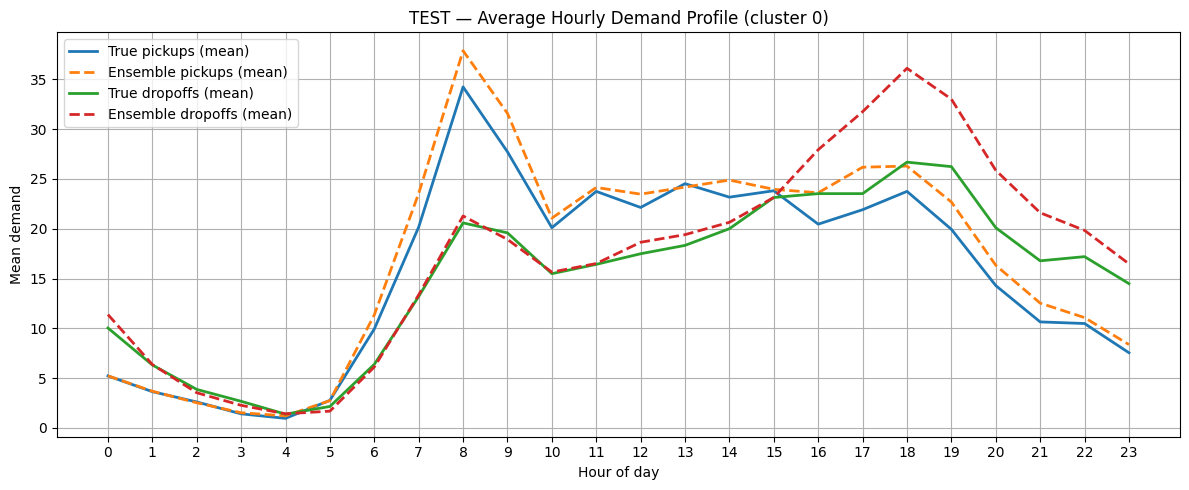

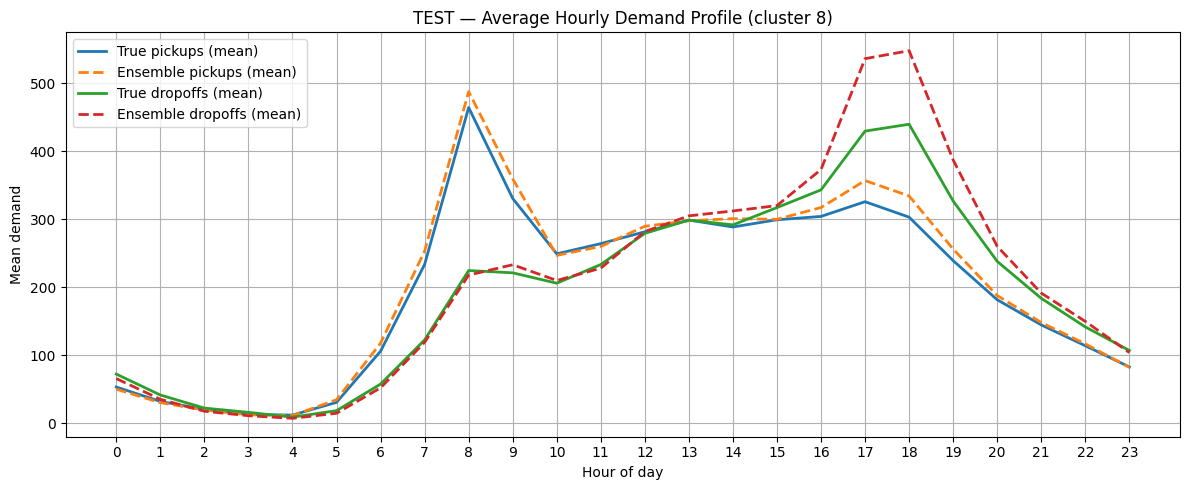

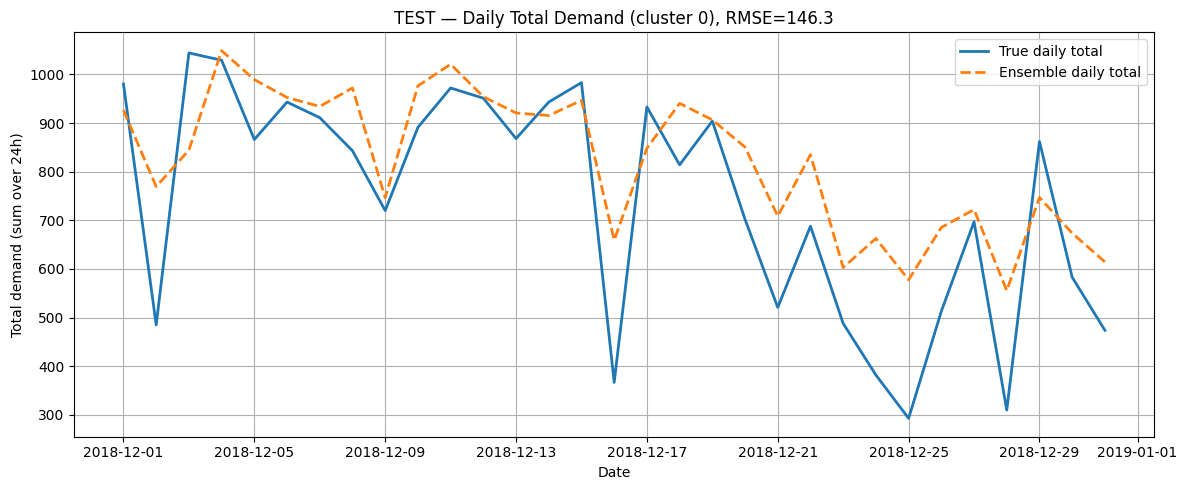

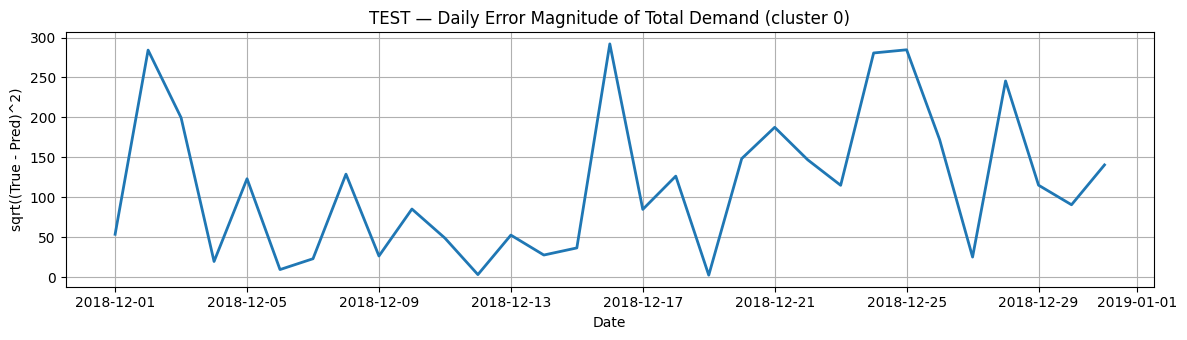

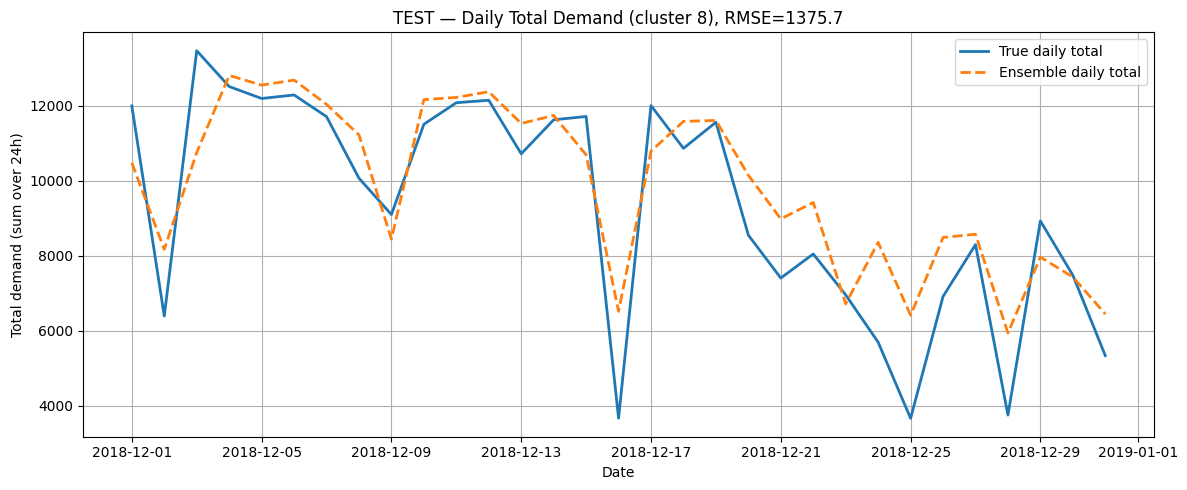

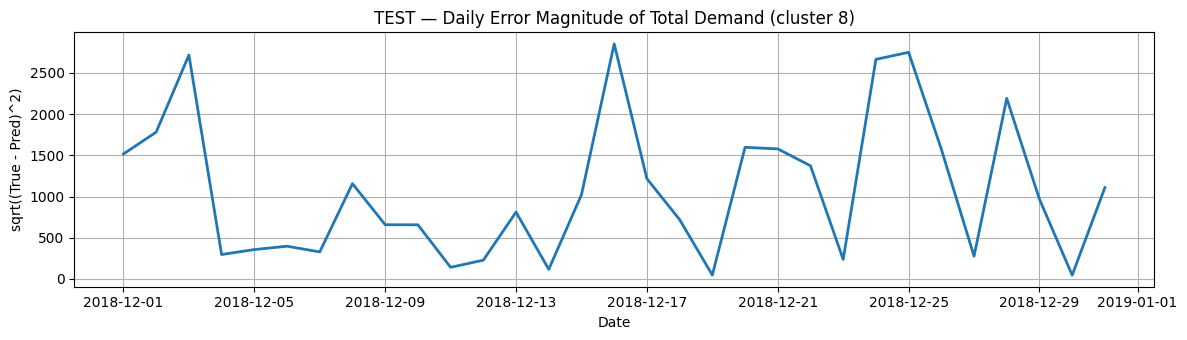

In [9]:
import matplotlib.pyplot as plt

test_df = all_df[all_df["split"] == "test"].copy()

# Ensure totals exist
test_df["y_true_total"] = test_df["y_true_pickups"] + test_df["y_true_dropoffs"]
test_df["y_pred_ens_total"] = test_df["y_pred_ens_pickups"] + test_df["y_pred_ens_dropoffs"]

# -------------------------
# 1) Average hourly profile per cluster (NOT aggregated across clusters)
# -------------------------
for cid in sorted(test_df["cluster_id"].unique()):
    dfc = test_df[test_df["cluster_id"] == cid].copy()

    hour_prof = dfc.groupby("hour").agg(
        true_pickups=("y_true_pickups", "mean"),
        pred_pickups=("y_pred_ens_pickups", "mean"),
        true_dropoffs=("y_true_dropoffs", "mean"),
        pred_dropoffs=("y_pred_ens_dropoffs", "mean"),
    ).sort_index()

    plt.figure(figsize=(12, 5))
    plt.plot(hour_prof.index, hour_prof["true_pickups"], linewidth=2, label="True pickups (mean)")
    plt.plot(hour_prof.index, hour_prof["pred_pickups"], linewidth=2, linestyle="--", label="Ensemble pickups (mean)")
    plt.plot(hour_prof.index, hour_prof["true_dropoffs"], linewidth=2, label="True dropoffs (mean)")
    plt.plot(hour_prof.index, hour_prof["pred_dropoffs"], linewidth=2, linestyle="--", label="Ensemble dropoffs (mean)")

    plt.title(f"TEST — Average Hourly Demand Profile (cluster {cid})")
    plt.xlabel("Hour of day")
    plt.ylabel("Mean demand")
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------
# 2) Daily totals per cluster (NOT aggregated across clusters)
# -------------------------
for cid in sorted(test_df["cluster_id"].unique()):
    dfc = test_df[test_df["cluster_id"] == cid].copy()

    daily = dfc.groupby("date")[["y_true_total", "y_pred_ens_total"]].sum().sort_index()

    daily["se_total"] = (daily["y_true_total"] - daily["y_pred_ens_total"]) ** 2
    rmse_daily = float(np.sqrt(daily["se_total"].mean()))

    plt.figure(figsize=(12, 5))
    plt.plot(daily.index, daily["y_true_total"], linewidth=2, label="True daily total")
    plt.plot(daily.index, daily["y_pred_ens_total"], linewidth=2, linestyle="--", label="Ensemble daily total")

    plt.title(f"TEST — Daily Total Demand (cluster {cid}), RMSE={rmse_daily:.1f}")
    plt.xlabel("Date")
    plt.ylabel("Total demand (sum over 24h)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.5))
    plt.plot(daily.index, np.sqrt(daily["se_total"]), linewidth=2)
    plt.title(f"TEST — Daily Error Magnitude of Total Demand (cluster {cid})")
    plt.xlabel("Date")
    plt.ylabel("sqrt((True - Pred)^2)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


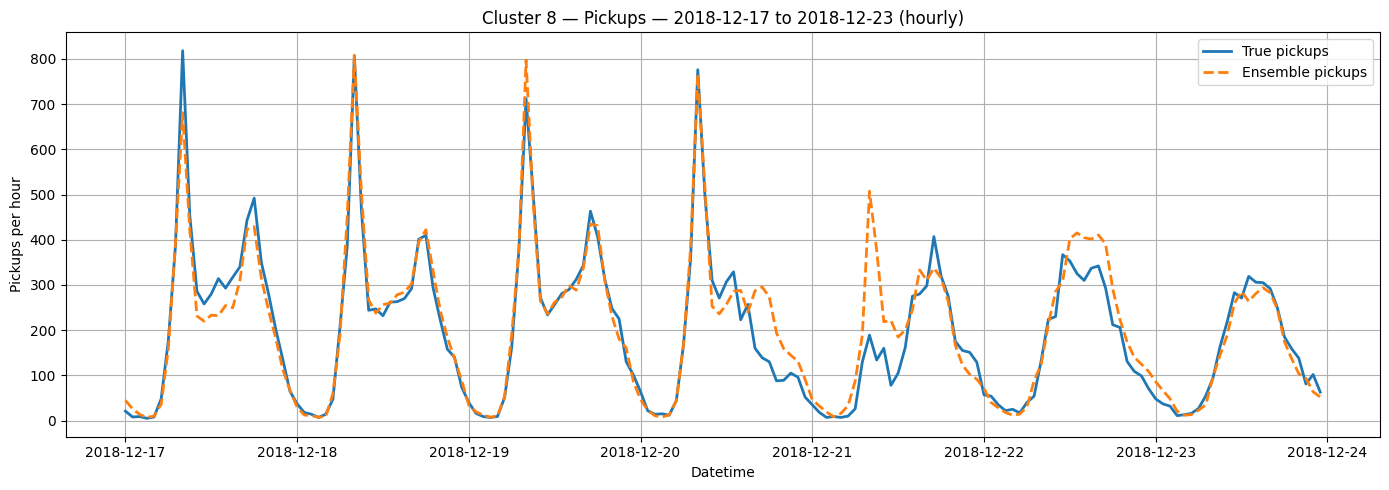

In [10]:
# Cell 10 (REPLACE): True pickups + Ensemble pickups — one December week (hourly, no means)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

CID = 8
START = pd.Timestamp("2018-12-17")          # pick the week start you want
END_EXCL = START + pd.Timedelta(days=7)     # exactly 7 days, exclusive end

# IMPORTANT: load from ONE model file to avoid inner-merge row drops (use this for the timeline)
dfc = load_preds_for_model_cluster("rf", CID).copy()
dfc = dfc[dfc["split"] == "test"].copy()

dfc["date"] = pd.to_datetime(dfc["date"]).dt.normalize()
dfc["datetime"] = dfc["date"] + pd.to_timedelta(dfc["hour"], unit="h")

win = dfc[(dfc["datetime"] >= START) & (dfc["datetime"] < END_EXCL)].sort_values("datetime").copy()
if len(win) == 0:
    raise ValueError(f"No rows found for cluster {CID} in [{START.date()} .. {END_EXCL.date()}).")

# Pull ensemble predictions, but DO NOT change the timeline:
# just map (datetime -> y_pred_ens_pickups) onto win.
ens = all_df[(all_df["split"] == "test") & (all_df["cluster_id"] == CID)].copy()
ens["date"] = pd.to_datetime(ens["date"]).dt.normalize()
ens["datetime"] = ens["date"] + pd.to_timedelta(ens["hour"], unit="h")

ens_map = ens.set_index("datetime")["y_pred_ens_pickups"]
win["y_pred_ens_pickups"] = win["datetime"].map(ens_map)

# Optional: warn if ensemble is missing for some hours (but still plot what exists)
missing = win["y_pred_ens_pickups"].isna().sum()
if missing:
    print(f"[WARN] Ensemble missing for {missing} / {len(win)} hours in this window (likely dropped during merge).")

plt.figure(figsize=(14, 5))
plt.plot(win["datetime"], win["y_true_pickups"], linewidth=2, label="True pickups")
plt.plot(win["datetime"], win["y_pred_ens_pickups"], linewidth=2, linestyle="--", label="Ensemble pickups")
plt.title(f"Cluster {CID} — Pickups — {START.date()} to {(END_EXCL - pd.Timedelta(days=1)).date()} (hourly)")
plt.xlabel("Datetime")
plt.ylabel("Pickups per hour")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from itertools import combinations

def rmse_col(df, true_col, pred_col):
    return float(np.sqrt(np.mean((df[true_col] - df[pred_col])**2)))

models = ["rf", "reg", "ts"]   # (exclude mlp if you truly don't want it)

pred_cols = {
    "rf":  "y_pred_rf_pickups",
    "reg": "y_pred_xgb_pickups",
    "ts":  "y_pred_ts_pickups",
}

def ens_pred(df, ms, weights=None):
    X = np.column_stack([df[pred_cols[m]].to_numpy() for m in ms])
    if weights is None:
        w = np.ones(len(ms)) / len(ms)
    else:
        w = np.array([weights[m] for m in ms], dtype=float)
        w = w / w.sum()
    return X @ w

val_df = all_df[all_df["split"] == VAL_SPLIT_NAME].copy()

# compare subsets (equal weights) on pickups
for r in range(1, len(models)+1):
    for ms in combinations(models, r):
        pred = ens_pred(val_df, ms)
        score = float(np.sqrt(np.mean((val_df["y_true_pickups"].to_numpy() - pred)**2)))
        print(f"{ms}: RMSE_pickups={score:.3f}")


('rf',): RMSE_pickups=84.557
('reg',): RMSE_pickups=34.821
('ts',): RMSE_pickups=91.816
('rf', 'reg'): RMSE_pickups=53.418
('rf', 'ts'): RMSE_pickups=84.824
('reg', 'ts'): RMSE_pickups=55.441
('rf', 'reg', 'ts'): RMSE_pickups=62.979


In [12]:
from itertools import combinations

def rmse_col(df, true_col, pred_col):
    return float(np.sqrt(np.mean((df[true_col] - df[pred_col])**2)))

models = ["rf", "reg", "ts"]   # (exclude mlp if you truly don't want it)

pred_cols = {
    "rf":  "y_pred_rf_dropoffs",
    "reg": "y_pred_xgb_dropoffs",
    "ts":  "y_pred_ts_dropoffs",
}

def ens_pred(df, ms, weights=None):
    X = np.column_stack([df[pred_cols[m]].to_numpy() for m in ms])
    if weights is None:
        w = np.ones(len(ms)) / len(ms)
    else:
        w = np.array([weights[m] for m in ms], dtype=float)
        w = w / w.sum()
    return X @ w

val_df = all_df[all_df["split"] == VAL_SPLIT_NAME].copy()

# compare subsets (equal weights) on dropoffs
for r in range(1, len(models)+1):
    for ms in combinations(models, r):
        pred = ens_pred(val_df, ms)
        score = float(np.sqrt(np.mean((val_df["y_true_dropoffs"].to_numpy() - pred)**2)))
        print(f"{ms}: RMSE_dropoffs={score:.3f}")


('rf',): RMSE_dropoffs=116.369
('reg',): RMSE_dropoffs=34.630
('ts',): RMSE_dropoffs=85.071
('rf', 'reg'): RMSE_dropoffs=68.462
('rf', 'ts'): RMSE_dropoffs=97.521
('reg', 'ts'): RMSE_dropoffs=53.129
('rf', 'reg', 'ts'): RMSE_dropoffs=71.572
